<a href="https://www.kaggle.com/code/jeffreyheo/pneumonia-chest-x-ray-project?scriptVersionId=106088100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob

#step 1: reading input data, creating categorical output labels (softmax classification task)
#step 2: image pre-processing (standardization), visualization
#step 2(a): data statistics (how many normal, bact_pneumonia, vir_pneumonia)
#step 3: data augmentation (increase size of data)
#step 4: load pre-trained model VGG-16 for transfer learning
#step 5: construct model, train the classification layer (metric should be confusion)
#step 6: test 

train_normal = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
train_pneumonia = '../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
test_normal = '../input/chest-xray-pneumonia/chest_xray/test/NORMAL'
test_pneumonia = '../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
validate_normal = '../input/chest-xray-pneumonia/chest_xray/val/NORMAL'
validate_pneumonia = '../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'


Image dimension:  (1858, 2090, 3)


2022-09-20 06:24:37.706818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 06:24:37.819199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 06:24:37.820234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 06:24:37.823771: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Resized Image Dimension:  (224, 224, 3)


Text(0.5, 1.0, 'Normal, Standardized')

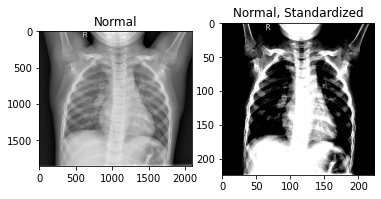

In [2]:
#get image dimension
img_sample = cv2.imread('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
dim = img_sample.shape
print('Image dimension: ', dim)
plt.subplot(1, 2, 1)
plt.imshow(img_sample)
plt.title('Normal')

#visualize standardization
img_stand_sample = cv2.resize(img_sample, (224,224))
img_stand_sample = tf.image.per_image_standardization(img_stand_sample)
new_dim = img_stand_sample.shape
print('Resized Image Dimension: ', new_dim)
plt.subplot(1, 2, 2)
plt.imshow(img_stand_sample)
plt.title('Normal, Standardized')

In [3]:
#loading data into pandas dataframe
df_train_normal = pd.DataFrame({'path': glob.glob(train_normal + '/*.jpeg'), 'label' : 'normal'})
df_train_bact_pneu = pd.DataFrame({'path' : glob.glob(train_pneumonia + '/person*_b*.jpeg'), 'label' : 'bacterial pneumonia'})
df_train_vir_pneu = pd.DataFrame({'path' : glob.glob(train_pneumonia + '/person*_v*.jpeg'), 'label' : 'viral pneumonia'})

df_test_normal = pd.DataFrame({'path': glob.glob(test_normal + '/*.jpeg'), 'label' : 'normal'})
df_test_bact_pneu = pd.DataFrame({'path' : glob.glob(test_pneumonia + '/person*_b*.jpeg'), 'label' : 'bacterial pneumonia'})
df_test_vir_pneu = pd.DataFrame({'path' : glob.glob(test_pneumonia + '/person*_v*.jpeg'), 'label' : 'viral pneumonia'})

df_val_normal = pd.DataFrame({'path': glob.glob(validate_normal + '/*.jpeg'), 'label' : 'normal'})
df_val_bact_pneu = pd.DataFrame({'path' : glob.glob(validate_pneumonia + '/person*_b*.jpeg'), 'label' : 'bacterial pneumonia'})
df_val_vir_pneu = pd.DataFrame({'path' : glob.glob(validate_pneumonia + '/person*_v*.jpeg'), 'label' : 'viral pneumonia'})


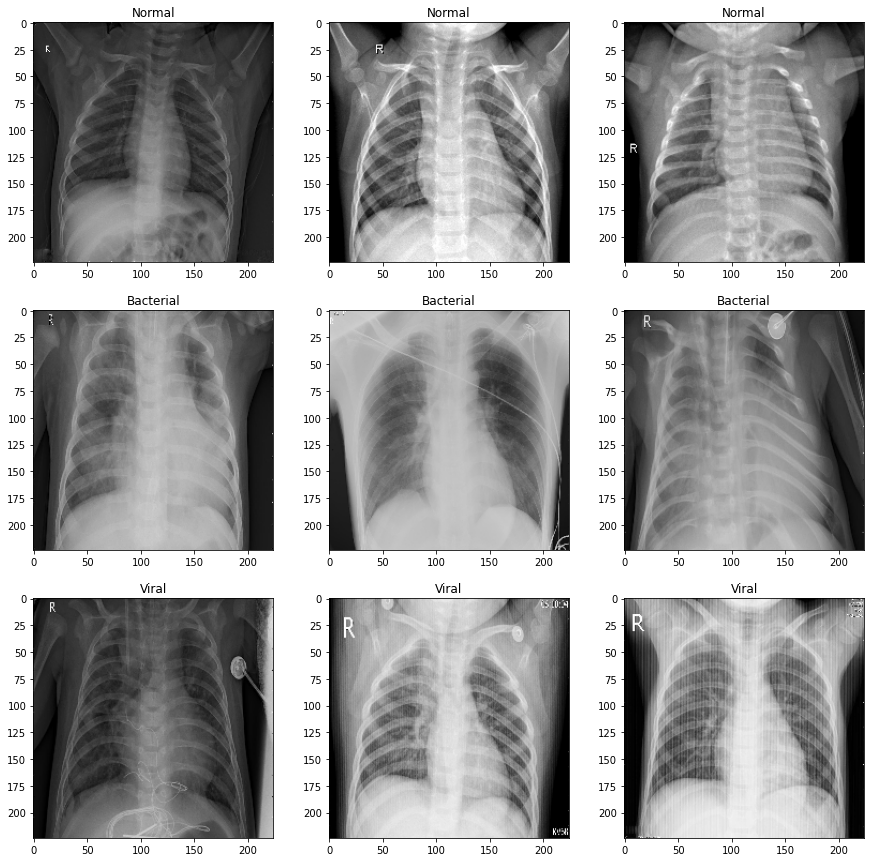

In [4]:
#data visualization
plt.figure(figsize=(15, 15))

i = 1
for index in range(3):
    img = cv2.imread(df_train_normal['path'][index])
    img = cv2.resize(img, (224, 224))
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title("Normal")
    i = i + 1
    
for index in range(3):
    img = cv2.imread(df_train_bact_pneu['path'][index])
    img = cv2.resize(img, (224, 224))
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title("Bacterial")
    i = i + 1
    
for index in range(3):
    img = cv2.imread(df_train_vir_pneu['path'][index])
    img = cv2.resize(img, (224, 224))
    plt.subplot(3,3,i)
    plt.imshow(img)
    plt.title("Viral")
    i = i + 1

Text(0.5, 1.0, 'Data Distribution')

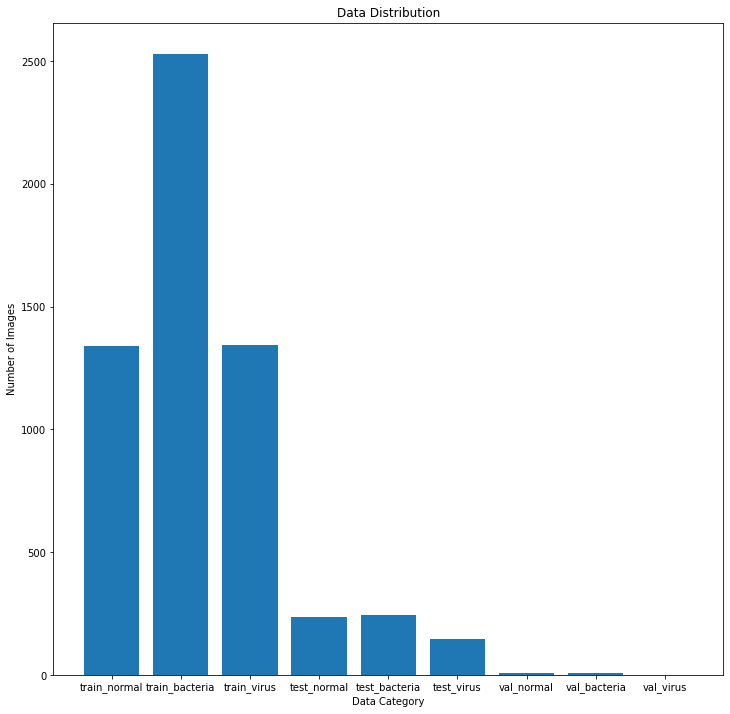

In [5]:
#data statistics
plt.figure(figsize=(12,12))
x_cat = ['train_normal', 'train_bacteria', 'train_virus', 'test_normal', 'test_bacteria', 'test_virus', 'val_normal', 'val_bacteria', 'val_virus']
y_cat = [len(df_train_normal), len(df_train_bact_pneu), len(df_train_vir_pneu), len(df_test_normal), 
         len(df_test_bact_pneu), len(df_test_vir_pneu), len(df_val_normal),len(df_val_bact_pneu),len(df_val_vir_pneu)]
plt.bar(x_cat, y_cat)
plt.xlabel('Data Category')
plt.ylabel('Number of Images')
plt.title('Data Distribution')

In [6]:
#merge dataset and shuffle dataframe
#note, our validation set is too small and non-uniform in distribution
#thus, we are going to merge the training set and validation set temporarily, then use validation split during fitting
df_train = pd.concat([df_train_normal, df_train_bact_pneu, df_train_vir_pneu, df_val_normal, df_val_bact_pneu, df_val_vir_pneu])
df_test = pd.concat([df_test_normal, df_test_bact_pneu, df_test_vir_pneu])

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_train, test_size=0.1)

In [7]:
df_train.head()


,path,label
5133,../input/chest-xray-pneumonia/chest_xray/train...,viral pneumonia
3169,../input/chest-xray-pneumonia/chest_xray/train...,viral pneumonia
4095,../input/chest-xray-pneumonia/chest_xray/train...,normal
4484,../input/chest-xray-pneumonia/chest_xray/train...,bacterial pneumonia
4382,../input/chest-xray-pneumonia/chest_xray/train...,normal


In [8]:
df_test.head()

,path,label
0,../input/chest-xray-pneumonia/chest_xray/test/...,normal
1,../input/chest-xray-pneumonia/chest_xray/test/...,normal
2,../input/chest-xray-pneumonia/chest_xray/test/...,normal
3,../input/chest-xray-pneumonia/chest_xray/test/...,viral pneumonia
4,../input/chest-xray-pneumonia/chest_xray/test/...,normal


In [9]:
df_val.head()

,path,label
2890,../input/chest-xray-pneumonia/chest_xray/train...,bacterial pneumonia
4758,../input/chest-xray-pneumonia/chest_xray/train...,normal
2825,../input/chest-xray-pneumonia/chest_xray/train...,bacterial pneumonia
118,../input/chest-xray-pneumonia/chest_xray/train...,bacterial pneumonia
4665,../input/chest-xray-pneumonia/chest_xray/train...,bacterial pneumonia


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)
val_datagen = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)
test_datagen = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True)


In [11]:
train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                    x_col = "path",
                                                    y_col = "label",
                                                    target_size = (150, 150),
                                                    class_mode = "categorical",
                                                    batch_size = 32,
            
                                                   )

validation_generator = val_datagen.flow_from_dataframe(dataframe = df_val,
                                                    x_col = "path",
                                                    y_col = "label",
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = "categorical",
            
                                                  )
test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                    x_col = "path",
                                                    y_col = "label",
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = "categorical",
            
                                                  )

Found 4708 validated image filenames belonging to 3 classes.
Found 524 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [12]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape= (150, 150, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation = 'softmax'),
])

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [13]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = 'accuracy')


In [14]:
history = model.fit(x = train_generator, validation_data = validation_generator, epochs = 25)

2022-09-20 06:24:55.047500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-09-20 06:24:57.371762: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


148/148 [==============================] - 97s 598ms/step - loss: 0.6752 - accuracy: 0.7472 - val_loss: 0.5599 - val_accuracy: 0.7385
Epoch 2/25
148/148 [==============================] - 54s 362ms/step - loss: 0.4310 - accuracy: 0.8180 - val_loss: 0.4687 - val_accuracy: 0.7958
Epoch 3/25
148/148 [==============================] - 52s 353ms/step - loss: 0.3555 - accuracy: 0.8488 - val_loss: 0.4397 - val_accuracy: 0.8015
Epoch 4/25
148/148 [==============================] - 54s 362ms/step - loss: 0.2934 - accuracy: 0.8762 - val_loss: 0.4468 - val_accuracy: 0.8187
Epoch 5/25
148/148 [==============================] - 53s 360ms/step - loss: 0.2256 - accuracy: 0.9108 - val_loss: 0.5548 - val_accuracy: 0.7748
Epoch 6/25
148/148 [==============================] - 53s 359ms/step - loss: 0.2103 - accuracy: 0.9161 - val_loss: 0.5839 - val_accuracy: 0.8187
Epoch 7/25
148/148 [==============================] - 52s 354ms/step - loss: 0.1699 - accuracy: 0.9339 - val_loss: 0.6906 - val_accuracy: 0.7

In [15]:
score = model.evaluate(test_generator)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

20/20 [==============================] - 10s 514ms/step - loss: 2.2264 - accuracy: 0.7244
Test loss:  2.2263731956481934
Test accuracy:  0.7243589758872986
